# XGBoost Regression Analysis

## Import Libraries

In [52]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error, auc, roc_curve

## Import Data

In [2]:
df = pd.read_parquet('data/combined_files.parquet')
df.head()

,power,knoxville_temperature_2m,knoxville_relative_humidity_2m,knoxville_precipitation,knoxville_rain,knoxville_snowfall,knoxville_snow_depth,knoxville_apparent_temperature,knoxville_cloud_cover,knoxville_wind_speed_10m,...,month,day_percent,hour,season_Fall,season_Spring,season_Summer,season_Winter,runtime,power_1hr,power_1day
0,13510,44.399300,95.629303,0.0,0.0,0.0,0.0,39.823086,0.0,1.890231,...,1,0.064516,0,False,False,False,True,24.0,13902.0,14421.0
1,13114,45.749298,94.351883,0.0,0.0,0.0,0.0,42.451595,13.0,1.200324,...,1,0.064516,1,False,False,False,True,25.0,13510.0,13940.0
2,12887,45.299301,94.991661,0.0,0.0,0.0,0.0,42.088787,4.0,1.101308,...,1,0.064516,2,False,False,False,True,26.0,13114.0,13621.0
3,12737,44.219299,95.956245,0.0,0.0,0.0,0.0,40.415550,51.0,1.368721,...,1,0.064516,3,False,False,False,True,27.0,12887.0,13406.0
4,12834,47.369301,91.849159,0.0,0.0,0.0,0.0,43.957150,39.0,1.417247,...,1,0.064516,4,False,False,False,True,28.0,12737.0,13258.0


In [14]:
# create date info for visualizations later
df_visuals = df[['year', 'month', 'hour', 'day_percent']].copy()
df_visuals['day'] = 1
df_visuals['first_of_month'] = pd.to_datetime(df_visuals[['year', 'month', 'day']])
df_visuals['day'] = df_visuals['day_percent'] * df_visuals['first_of_month'].dt.daysinmonth
df_visuals['date_no_hour'] = pd.to_datetime(df_visuals[['year', 'month', 'day']])
df_visuals['date'] = df_visuals['date_no_hour'] + pd.to_timedelta(df_visuals['hour'], unit='h')
df_visuals.head()

,year,month,hour,day_percent,day,first_of_month,date_no_hour,date
0,2023,1,0,0.064516,2.0,2023-01-01,2023-01-02,2023-01-02 00:00:00
1,2023,1,1,0.064516,2.0,2023-01-01,2023-01-02,2023-01-02 01:00:00
2,2023,1,2,0.064516,2.0,2023-01-01,2023-01-02,2023-01-02 02:00:00
3,2023,1,3,0.064516,2.0,2023-01-01,2023-01-02,2023-01-02 03:00:00
4,2023,1,4,0.064516,2.0,2023-01-01,2023-01-02,2023-01-02 04:00:00


## Split Into Test/Train

In [40]:
X = df.drop(columns='power')
y = df[['power']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=13)

In [41]:
# make dataframes for test/train visualizations
df_visuals_train = df_visuals.loc[X_train.index]
df_visuals_test = df_visuals.loc[X_test.index]

## Run initial model

In [47]:
model = XGBRegressor(random_state=13)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [49]:
# get results
print('Training Results')
print('R2 Train:', r2_score(y_train, y_pred_train))
print('RMSE Train:', root_mean_squared_error(y_train, y_pred_train))
print('MAPE Train:', mean_absolute_percentage_error(y_train, y_pred_train))

print('\nTest Results:')
print('R2 Test:', r2_score(y_test, y_pred))
print('RMSE Test:', root_mean_squared_error(y_test, y_pred))
print('MAPE Test:', mean_absolute_percentage_error(y_test, y_pred))

Training Results
R2 Train: 0.9989833235740662
RMSE Train: 119.87234497070312
MAPE Train: 0.005046646110713482

Test Results:
R2 Test: 0.9960551857948303
RMSE Test: 237.3669891357422
MAPE Test: 0.009343331679701805


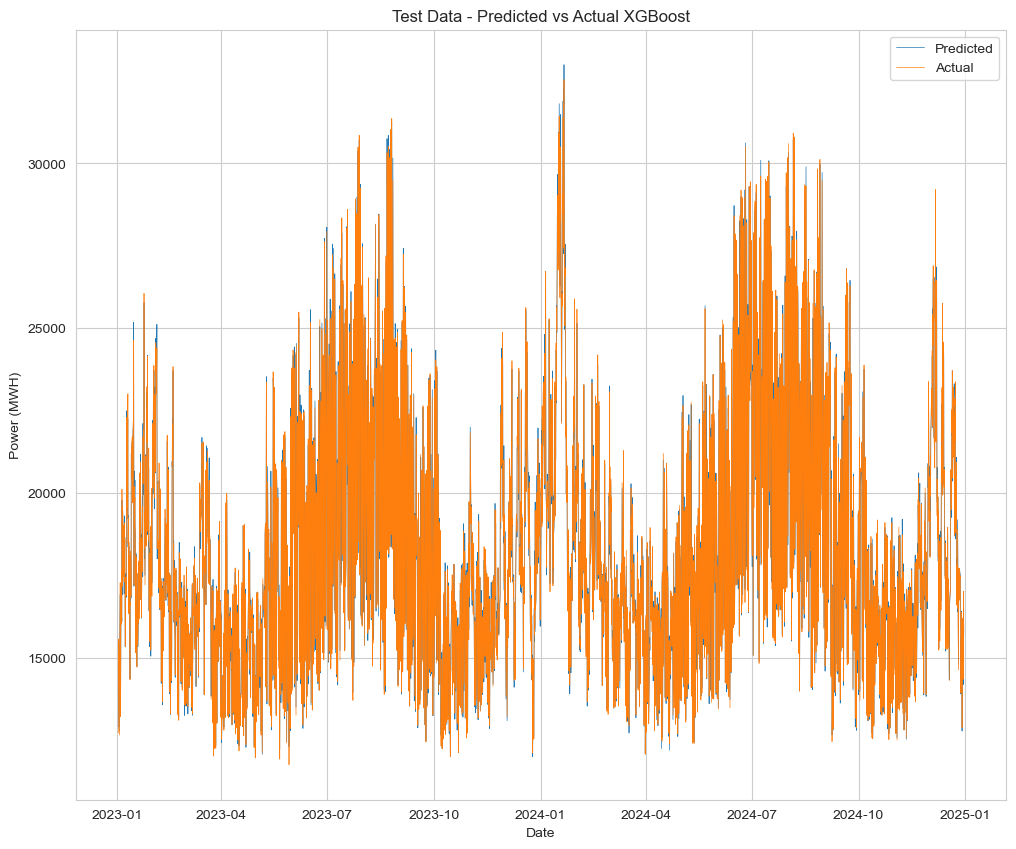

In [45]:
# plot results
plt.figure(figsize=(12,10))
df_test = pd.DataFrame({'Date': df_visuals_test['date'].to_numpy(),
                        'Actual': y_test['power'].to_numpy(),
                        'Predicted': y_pred})


sns.lineplot(df_test, x='Date', y='Predicted', label='Predicted', linewidth=0.5)
sns.lineplot(df_test, x='Date', y='Actual', label='Actual', linewidth=0.5)
plt.title('Test Data - Predicted vs Actual XGBoost')
plt.xlabel('Date')
plt.ylabel('Power (MWH)')
plt.legend()

Text(0.5, 1.0, 'Residuals vs Predicted - XGBoost')

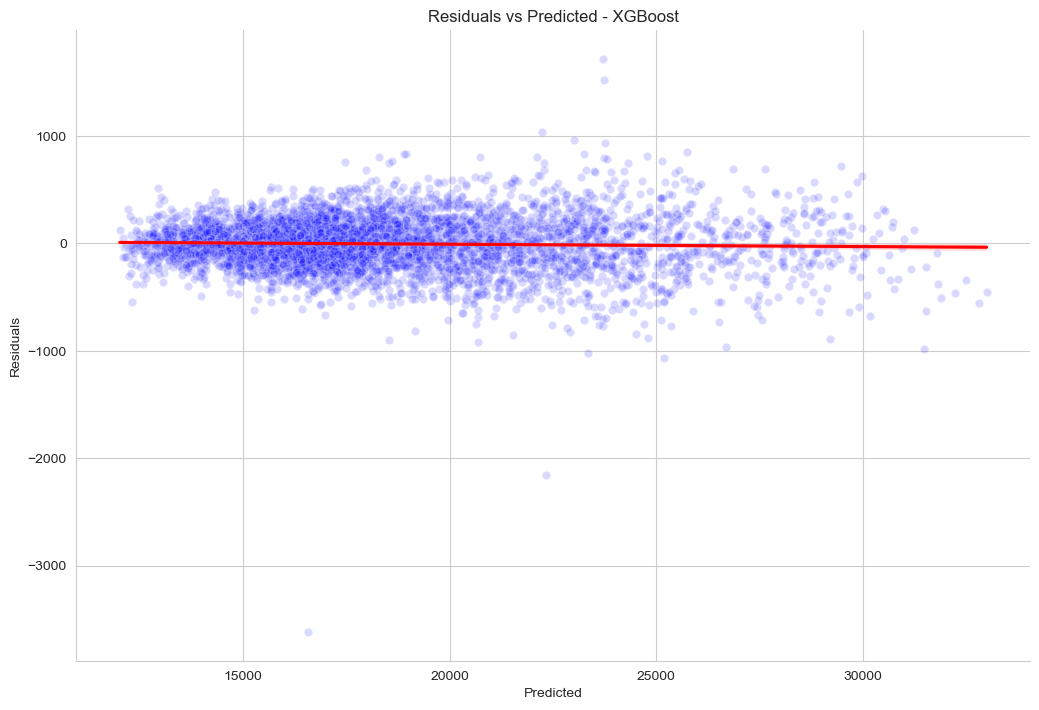

In [50]:
# plot residuals
df_test['Residuals'] = df_test['Actual'] - df_test['Predicted']
sns.lmplot(x='Predicted', y='Residuals', data=df_test, height=7,
          aspect=1.5, scatter_kws={'alpha': 0.15, 'color': 'blue', 'edgecolor': 'white'},
          line_kws={'color': 'red'})
plt.title('Residuals vs Predicted - XGBoost')

In [51]:
df_test[(df_test['Residuals']<-1000)|(df_test['Residuals']>1000)]

,Date,Actual,Predicted,Residuals
1730,2024-01-05 10:00:00,24121,25185.935547,-1064.935547
2324,2023-07-01 13:00:00,25251,23725.082031,1525.917969
2339,2024-09-06 19:00:00,22314,23337.826172,-1023.826172
2841,2024-07-01 12:00:00,23276,22238.656250,1037.343750
4025,2024-07-10 00:00:00,20167,22320.908203,-2153.908203
4395,2023-04-19 02:00:00,12946,16565.400391,-3619.400391
4478,2024-07-30 11:00:00,25439,23718.613281,1720.386719


## Hyperparamter Tuning

In [53]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'random_state': [13]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)
print('Best Parameters:', grid_search.best_params_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'random_state': 13, 'subsample': 1.0}


In [54]:
model = XGBRegressor(**grid_search.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [55]:
# get results
print('Training Results')
print('R2 Train:', r2_score(y_train, y_pred_train))
print('RMSE Train:', root_mean_squared_error(y_train, y_pred_train))
print('MAPE Train:', mean_absolute_percentage_error(y_train, y_pred_train))

print('\nTest Results:')
print('R2 Test:', r2_score(y_test, y_pred))
print('RMSE Test:', root_mean_squared_error(y_test, y_pred))
print('MAPE Test:', mean_absolute_percentage_error(y_test, y_pred))

Training Results
R2 Train: 0.9996442198753357
RMSE Train: 70.9111099243164
MAPE Train: 0.0029537160880863667

Test Results:
R2 Test: 0.9967526793479919
RMSE Test: 215.3625946044922
MAPE Test: 0.008341636508703232


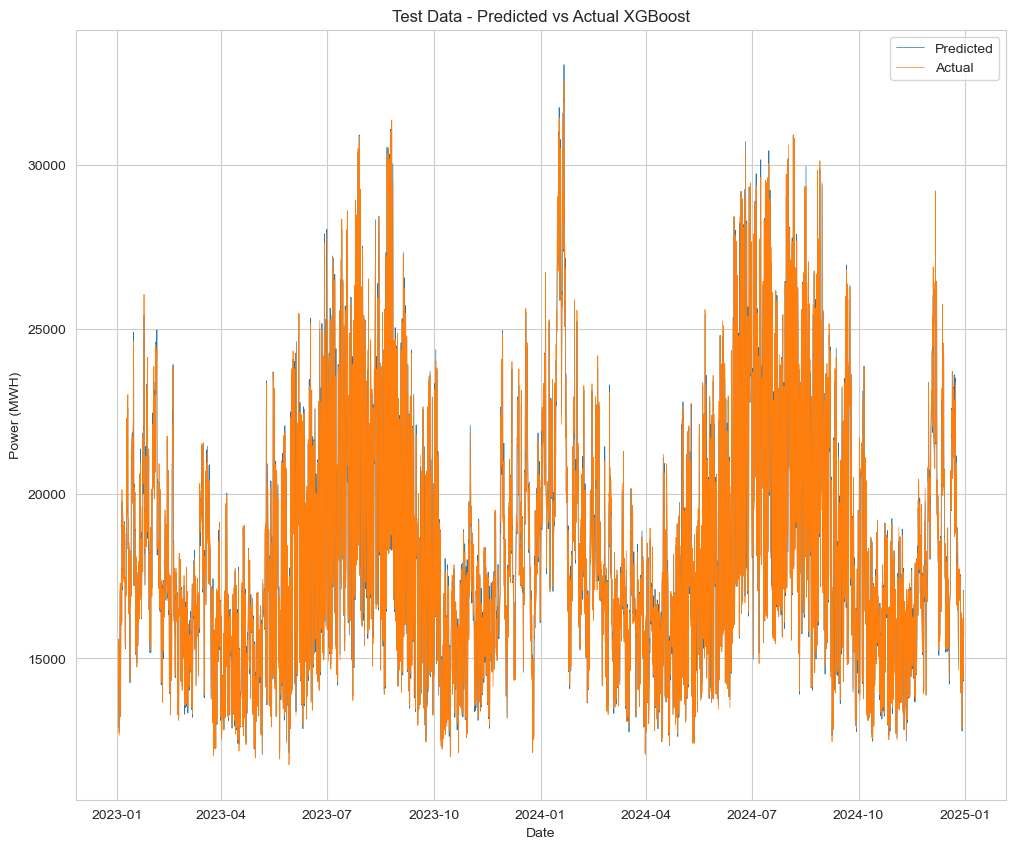

In [66]:
# plot results
plt.figure(figsize=(12,10))
df_test = pd.DataFrame({'Date': df_visuals_test['date'].to_numpy(),
                        'Actual': y_test['power'].to_numpy(),
                        'Predicted': y_pred})


sns.lineplot(df_test, x='Date', y='Predicted', label='Predicted', linewidth=0.5)
sns.lineplot(df_test, x='Date', y='Actual', label='Actual', linewidth=0.5)
plt.title('Test Data - Predicted vs Actual XGBoost')
plt.xlabel('Date')
plt.ylabel('Power (MWH)')
plt.legend()

Text(0.5, 1.0, 'Residuals vs Predicted - XGBoost')

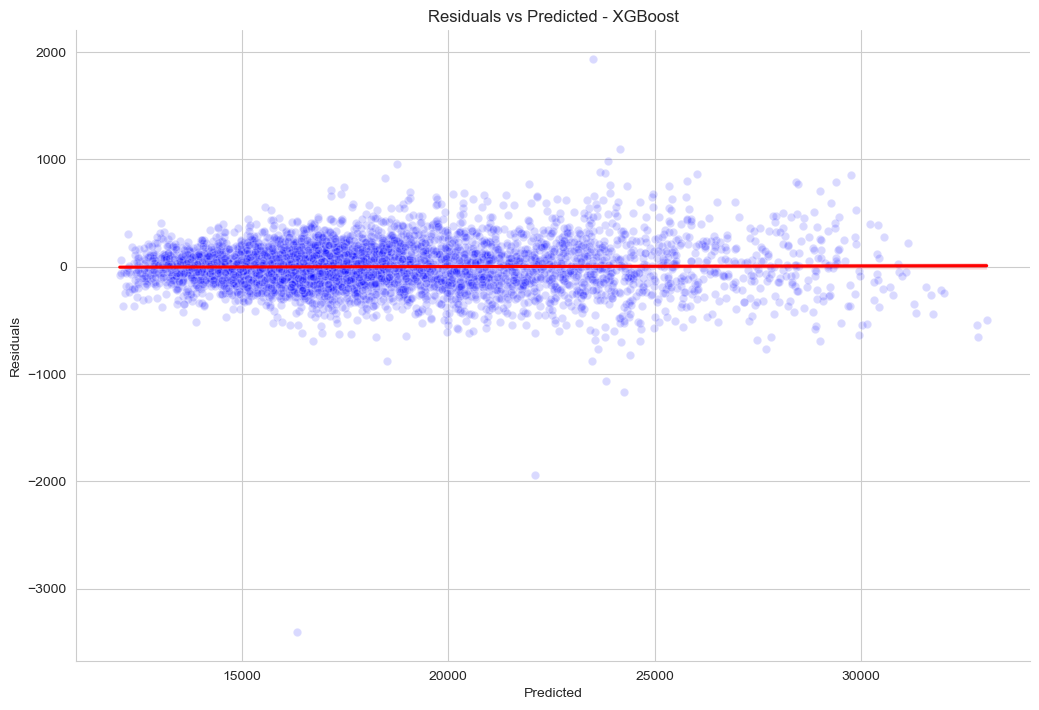

In [67]:
# plot residuals
df_test['Residuals'] = df_test['Actual'] - df_test['Predicted']
sns.lmplot(x='Predicted', y='Residuals', data=df_test, height=7,
          aspect=1.5, scatter_kws={'alpha': 0.15, 'color': 'blue', 'edgecolor': 'white'},
          line_kws={'color': 'red'})
plt.title('Residuals vs Predicted - XGBoost')

In [68]:
df_test[(df_test['Residuals']<-1000)|(df_test['Residuals']>1000)]

,Date,Actual,Predicted,Residuals
2324,2023-07-01 13:00:00,25251,24153.914062,1097.085938
2641,2023-07-21 18:00:00,23092,24262.455078,-1170.455078
4025,2024-07-10 00:00:00,20167,22105.988281,-1938.988281
4395,2023-04-19 02:00:00,12946,16351.807617,-3405.807617
4478,2024-07-30 11:00:00,25439,23501.884766,1937.115234
4510,2023-07-01 18:00:00,22755,23821.207031,-1066.207031


In [65]:
# look at feature importance
df_features = pd.DataFrame({'Features': list(X.columns),
                            'Values': model.feature_importances_})
df_features.sort_values(by='Values', ascending=False).head(10)

,Features,Values
54,power_1hr,0.922656
28,nashville_temperature_2m,0.010433
37,nashville_is_day,0.007797
48,hour,0.007781
23,memphis_is_day,0.006211
34,nashville_apparent_temperature,0.006044
9,knoxville_is_day,0.005939
0,knoxville_temperature_2m,0.004628
6,knoxville_apparent_temperature,0.003200
38,nashville_sunshine_duration,0.002657
